# Learning diffusion with a neural partial differential equation

In [1]:
using LinearAlgebra

using DifferentialEquations
using Flux
using DiffEqFlux

using Plots
default(fmt = :png)

We want to solve the heat (or diffusion) equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in \left[-\frac{1}{2}, \frac{1}{2}\right], \quad x\left(-\frac{1}{2}\right) = x\left(\frac{1}{2}\right)$$

Let's go with $N = 16$ grid points and $\kappa = 1$.

In [2]:
const N = 16
const L = 1
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

-0.5:0.06666666666666667:0.5

Discretizing the spatial derivative with a second-order centered finite-difference

$$\frac{\partial u_i}{\partial t} = \frac{\partial^2 u}{\partial x^2} \approx \kappa \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta x^2}$$

we get a system of $N$ coupled ODEs which can be described as

$$ \frac{\partial u}{\partial t} = Au $$

where $A$ is a matrix.

In [3]:
 d = -2 * ones(N) # Diagonal
sd = ones(N-1)    # Sub-diagonals
A = Array(Tridiagonal(sd, d, sd))

# Impose periodic boundary conditions
A[1, N] = 1
A[N, 1] = 1

# Dimensionalize A
A_diffusion = (κ/Δx^2) .* A

function diffusion(∂u∂t, u, p, t)
    ∂u∂t .= A_diffusion * u
    return 
end

diffusion (generic function with 1 method)

Let's generate an initial condition

$$ u_0(x) = e^{-100x^2} $$

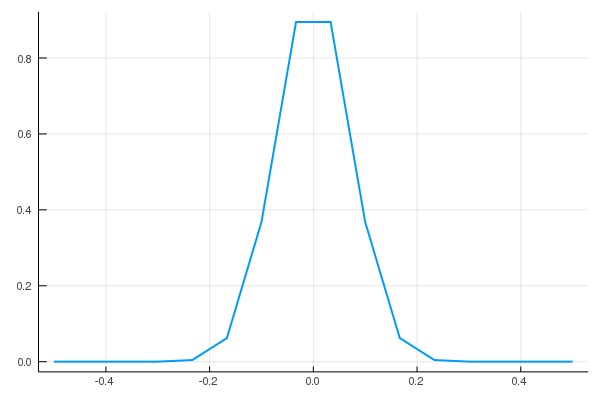

In [30]:
u₀ = @. exp(-100*x^2)

plot(x, u₀, linewidth=2, label="")

We'll pick 30 equally spaced times between $t = 0$ and $t = 0.1$ to save the state of the PDE.

In [31]:
tspan = (0.0, 0.1)
datasize = 30
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.0034482758620689655:0.1

Set up and solve the PDE.

In [32]:
prob = ODEProblem(diffusion, u₀, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

16×30 Array{Float64,2}:
 1.38879e-11  0.000160344  0.00215047  …  0.158223  0.159223  0.160099
 6.99705e-9   0.00087666   0.00636828     0.159464  0.160304  0.161033
 1.44928e-6   0.00462848   0.0199546      0.161636  0.16221   0.16272 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 1.44928e-6   0.00462848   0.0199546      0.161636  0

Let's plot the solution

In [33]:
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")

Now let's create a two-layer neural network to see if we can learn diffusion

In [34]:
dudt_NN = Chain(Dense(N, N))

Chain(Dense(16, 16))

Set up a neural PDE that solves the system of ODEs described by

$$ \frac{\partial u}{\partial t} = \text{NN}(u) $$

In [35]:
ps = Flux.params(dudt_NN)
neural_pde_prediction(u₀) = neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

neural_pde_prediction (generic function with 1 method)

Define the loss/objective function to be

$$ \left| u(x, t) - u_{NN}(x, t) \right|^2 \approx \sum_{n=1}^{N_t} \sum_{i=1}^{N_x} \left| u_i^n - (u_{NN})_i^n \right|^2 $$

In [36]:
loss_function(u₀, u_data) = sum(abs2, u_data .- neural_pde_prediction(u₀))

loss_function (generic function with 1 method)

Use the Adam optimization algorithm (adaptive moment estimation?). Seems to be recommended as a good default.

In [46]:
opt = ADAM(0.5)

data = [(u₀, ode_data)]

1-element Array{Tuple{Array{Float64,1},Array{Float64,2}},1}:
 ([1.3887943864964021e-11, 6.997045994265065e-9, 1.4492788871477636e-6, 0.00012340980408667956, 0.004320239474094066, 0.06217652402211632, 0.3678794411714422, 0.8948393168143698, 0.8948393168143698, 0.3678794411714422, 0.06217652402211632, 0.004320239474094066, 0.00012340980408667956, 1.4492788871477636e-6, 6.997045994265065e-9, 1.3887943864964021e-11], [1.3887943864964021e-11 0.0001603437480643901 … 0.15922318130688168 0.16009927057555876; 6.997045994265065e-9 0.0008766600900401355 … 0.16030408637417504 0.1610333109799329; … ; 6.997045994265065e-9 0.0008766600900401355 … 0.16030408637417504 0.1610333109799329; 1.3887943864964021e-11 0.0001603437480643901 … 0.15922318130688168 0.16009927057555876])

Define a callback function to observe training in progress and stop once loss is acceptable.

In [47]:
cb = function ()
  loss = loss_function(u₀, ode_data)
  println("loss = $loss")
end

cb()

loss = 0.7429576490755748 (tracked)


Training!

In [48]:
for _ in 1:250
    Flux.train!(loss_function, ps, data, opt, cb = cb)
end

loss = 1.059814068137191 (tracked)
loss = 2.387718699703983 (tracked)
loss = 0.7453300021054322 (tracked)
loss = 1.1772392438691546 (tracked)
loss = 1.5483170714634633 (tracked)
loss = 1.1854438773572613 (tracked)
loss = 0.6999010990587144 (tracked)
loss = 0.6325103966013785 (tracked)
loss = 0.9275444284828881 (tracked)
loss = 1.0137482768928447 (tracked)
loss = 0.7801420638420751 (tracked)
loss = 0.5872540827480337 (tracked)
loss = 0.5800416177935799 (tracked)
loss = 0.6605644757856973 (tracked)
loss = 0.707842010043042 (tracked)
loss = 0.6690835489791722 (tracked)
loss = 0.5690005855336869 (tracked)
loss = 0.4800015136514653 (tracked)
loss = 0.4613791247822881 (tracked)
loss = 0.5052313502581905 (tracked)
loss = 0.5461923398967733 (tracked)
loss = 0.532701790431881 (tracked)
loss = 0.4752610882267516 (tracked)
loss = 0.4219150330323796 (tracked)
loss = 0.40532353379623526 (tracked)
loss = 0.41937761373321336 (tracked)
loss = 0.435259658136386 (tracked)
loss = 0.4302888088481038 (trac

Let's see how well it fit the training data.

In [51]:
nn_pred = Flux.data(neural_pde_prediction(u₀))

@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 1), label="Neural PDE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")

Let's see how well it fits

$$ u_0(x) = 1 - cos(2\pi x) $$

In [52]:
u₀_cos = @. 1 - cos(2π * x)

prob = ODEProblem(diffusion, u₀_cos, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

nn_pred = Flux.data(neural_pde_prediction(u₀_cos))
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 2), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 2), label="Neural ODE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")